In [123]:
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import os
import sys
import scvelo as scv
scv.settings.verbosity=1
import scvi
from tqdm.notebook import tqdm

# Jupyter stuff
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

# custom
at_home = False if '/fast/work/users/' in os.getcwd() else True
signatures_path = '/home/peidli/utils/scrnaseq_signature_collection/' if at_home else '/fast/work/users/peidlis_c/utils/scrnaseq_signature_collection/'
tmp_path = '/fast/scratch/users/peidlis_c/tmp/'
utils_path = '/extra/stefan/utils/scrnaseq_utils/' if at_home else '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/'
sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *
data_path = '/extra/stefan/public_data/' if at_home else '/fast/work/users/peidlis_c/data/'

figure_path = '../../figures/'

%matplotlib inline

# Load data

In [21]:
# human
MelmsIzar290421_data = sc.read("/fast/scratch/users/peidlis_c/MelmsIzar290421_data.h5")
LiaoZhang120520_data = sc.read("/fast/scratch/users/peidlis_c/LiaoZhang120520_data.h5")
# GrantWunderink110121_data = sc.read("/fast/scratch/users/peidlis_c/GrantWunderink110121_data.h5")
ChuaEils290620_data = sc.read("/fast/scratch/users/peidlis_c/ChuaEils290620_data.h5")

# hamster data
bdata = sc.read("/fast/scratch/users/peidlis_c/cov19_hamster_data.h5")

# Signaling

In [123]:
df1 = MelmsIzar290421_data.obs.copy()
df1['dataset'] = 'MelmsIzar290421'
df1.celltype = df1.celltype.astype(str)
df1['orig.ident'] = df1.sample_id

bdata.obs['disease'] = ['healthy' if t=='D0' else 'recovered COVID19' if t=='E14' else 'COVID19' for t in bdata.obs.time]
df2 = bdata.obs.copy()
df2.celltype = df2.celltype.astype(str)
df2['dataset'] = df2['organism']

df3 = LiaoZhang120520_data.obs.copy()
df3['dataset'] = 'LiaoZhang120520'
df3.celltype = df3.celltype.astype(str)
df3['orig.ident'] = df3.sample_id

# df4 = GrantWunderink110121_data.obs.copy()
# df4['dataset'] = 'GrantWunderink110121'
# df4.celltype = df4.celltype_2.astype(str)
# df4['orig.ident'] = df4.sample_id

df5 = ChuaEils290620_data.obs.copy()
df5['dataset'] = 'ChuaEils290620'
df5.celltype = df5.celltype.astype(str)
df5['orig.ident'] = df5.sample_id


df = pd.concat([df1, df2, df3, df5], axis=0)
df['organism_disease'] = [f'{x} {y}' for x,y in zip(df.organism, df.disease)]
df['dataset_disease'] = [f'{x} {y}' for x,y in zip(df.dataset, df.disease)]

In [98]:
# X = df.value_counts(['dataset', 'celltype', 'disease'], sort=False).reset_index()

# Y = X.pivot(index='celltype', columns=['dataset', 'disease'], values=0)

# pl.figure(figsize=[20,6])
# sns.heatmap(Y.T>0)

In [124]:
# a single healthy human neutro....
len(df[df.celltype.isin(['Neutrophil', 'Neutrophils', 'Neu']) & (df.organism=='human') & (df.disease=='healthy')])

1

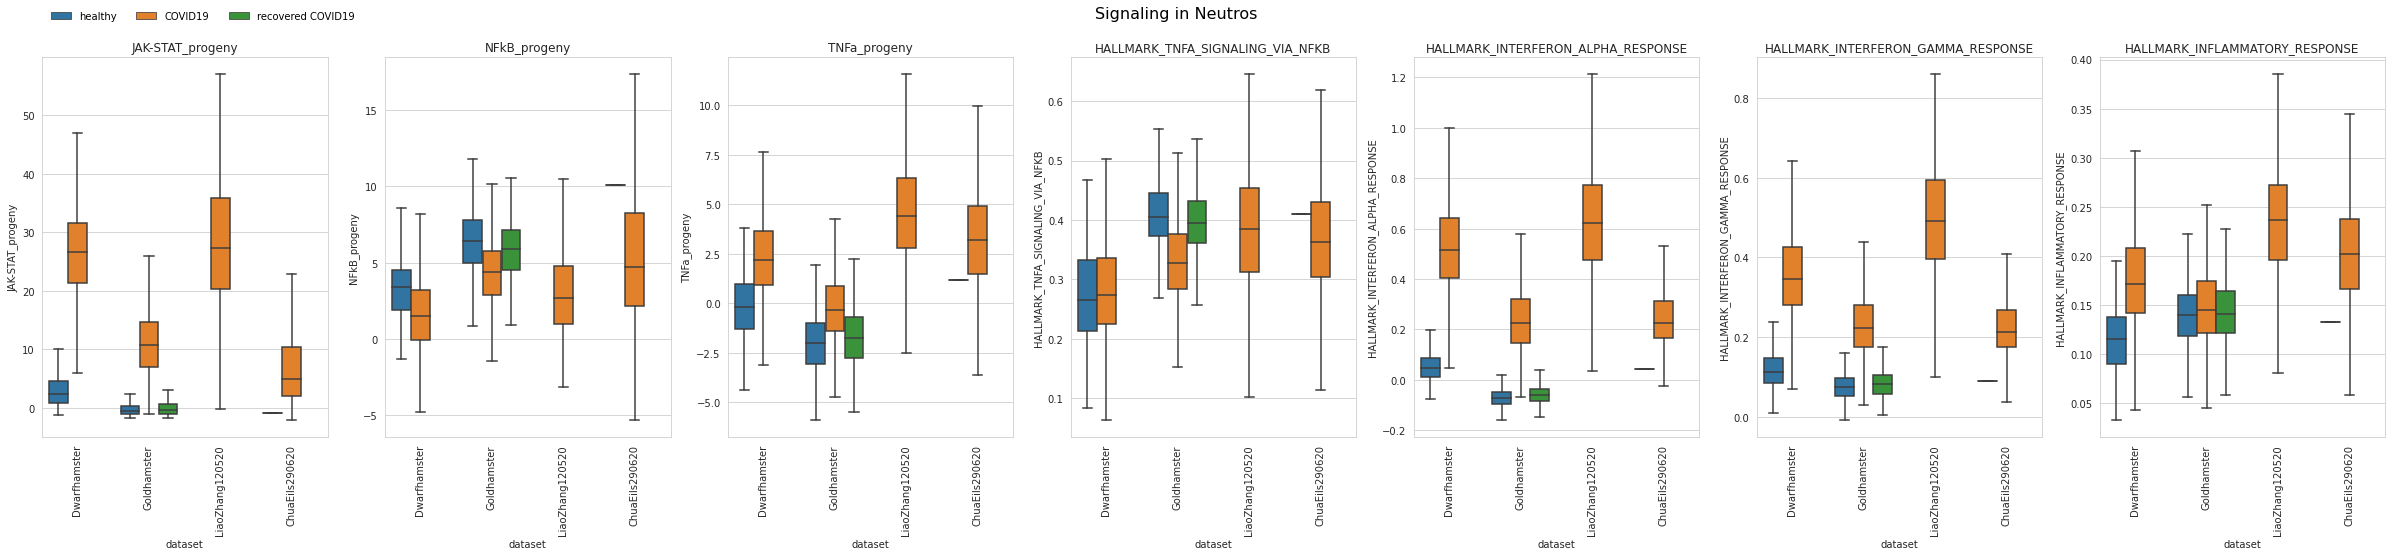

In [14]:
# Problem: No human healthy neutros!
sdf = df[df.celltype.isin(['Neutrophil', 'Neutrophils', 'Neu'])]

hm_keys = ['HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_INFLAMMATORY_RESPONSE']
keys = ['JAK-STAT_progeny', 'NFkB_progeny', 'TNFa_progeny'] + hm_keys

with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1,len(keys), figsize=[6*len(keys), 7])
for key, ax in zip(keys, axs):
    sns.boxplot(data=sdf, x='dataset', y=key, showfliers=False, ax=ax, hue='disease')
    ax.set_title(key)
    if ax!=axs[0]:
        ax.get_legend().remove()
    else:
        sns.move_legend(ax, loc='upper right')#, bbox_to_anchor=(1, 1))
    ax.set_title(key)
    ax.tick_params(axis='x', labelrotation=90)

sns.move_legend(
    axs[0], "lower left",
    bbox_to_anchor=(0, 1.07), ncol=3, title=None, frameon=False,
)
pl.suptitle('Signaling in Neutros', fontsize=16)
    
pl.show()

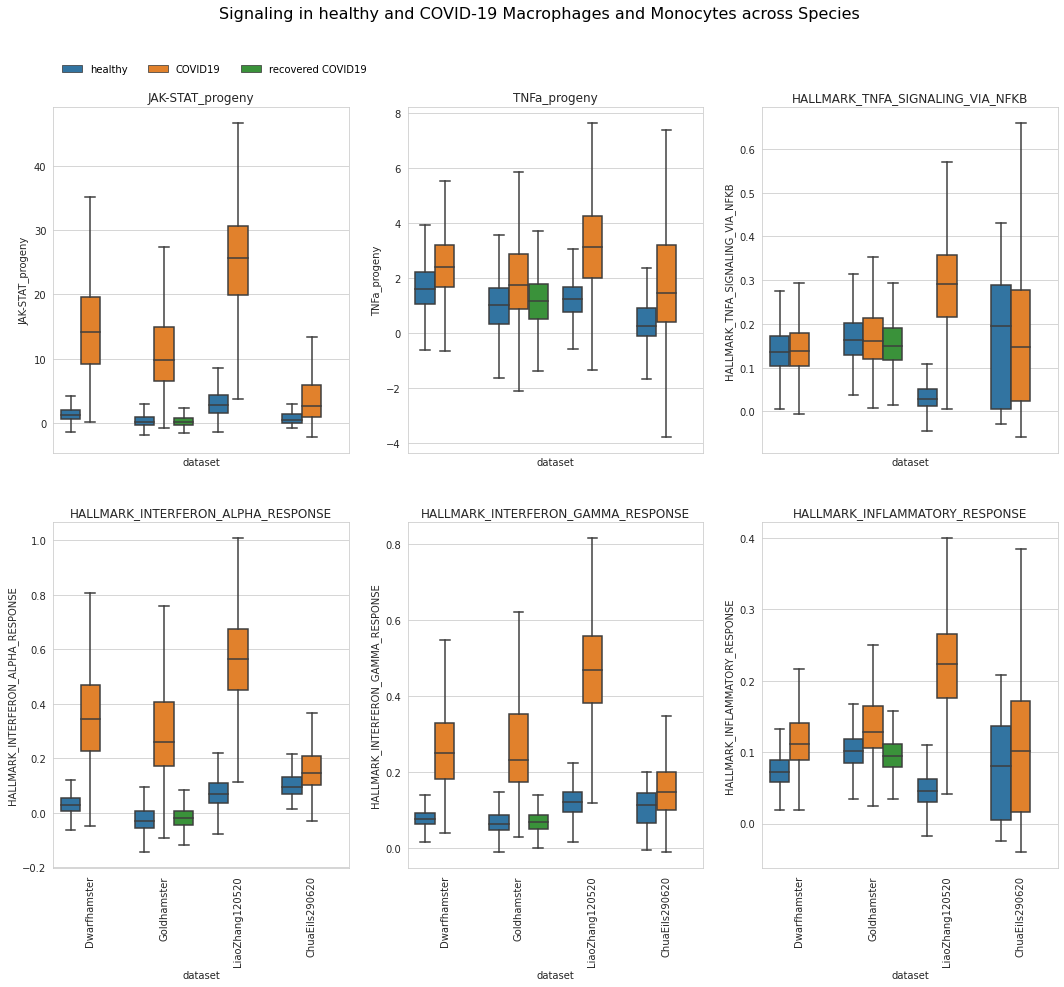

In [23]:
# Macros and Monos
sdf = df[df.celltype.isin(['Macrophages', 'Monocytes', 'nrMa', 'rMa', 'MoD-Ma','InterstitialMacrophages', 'MonocyticMacrophages', 'Treml4+Macrophages', 'AlveolarMacrophages'])]

hm_keys = ['HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_INFLAMMATORY_RESPONSE']
keys = ['JAK-STAT_progeny', 'TNFa_progeny'] + hm_keys

with sns.axes_style('whitegrid'):
#     fig, axs = pl.subplots(1,len(keys), figsize=[6*len(keys), 7])
    fig, axs = pl.subplots(2,int(len(keys)/2), figsize=[6*len(keys)/2, 7*2], sharex=True)
    axs = np.ravel(axs)
for key, ax in zip(keys, axs):
    sns.boxplot(data=sdf, x='dataset', y=key, showfliers=False, ax=ax, hue='disease')
    ax.set_title(key)
    if ax!=axs[0]:
        ax.get_legend().remove()
    else:
        sns.move_legend(ax, loc='upper right')#, bbox_to_anchor=(1, 1))
    ax.set_title(key)
    ax.tick_params(axis='x', labelrotation=90)

sns.move_legend(
    axs[0], "lower left",
    bbox_to_anchor=(0, 1.07), ncol=3, title=None, frameon=False,
)
pl.suptitle('Signaling in healthy and COVID-19 Macrophages and Monocytes across Species', fontsize=16)
    
pl.show()

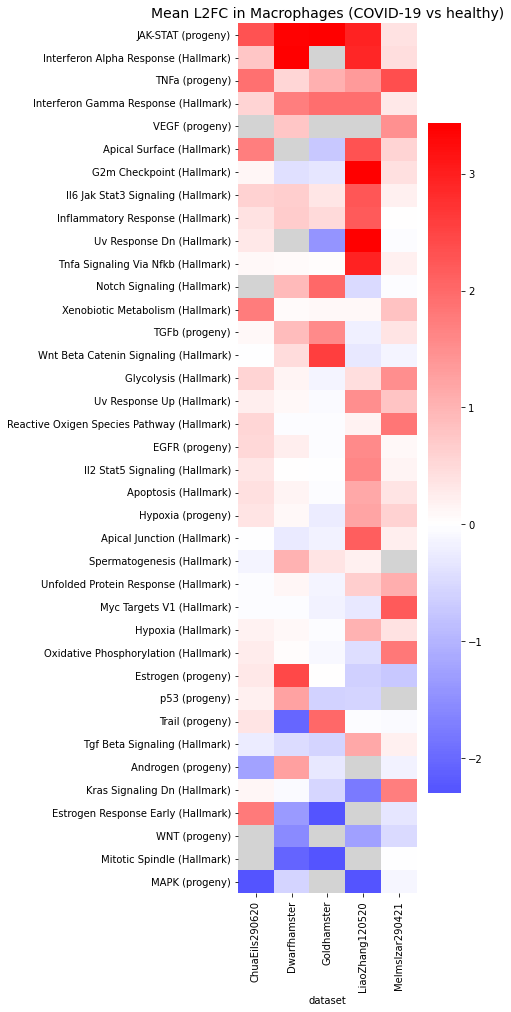

In [191]:
# Macros and Monos
sdf = df[df.celltype.isin(['Macrophages', 'Monocytes', 'nrMa', 'rMa', 'MoD-Ma','InterstitialMacrophages', 'MonocyticMacrophages', 'Treml4+Macrophages', 'AlveolarMacrophages'])]
keys = ['Androgen_progeny', 'EGFR_progeny', 'Estrogen_progeny', 'Hypoxia_progeny', 'JAK-STAT_progeny', 'MAPK_progeny', 'NFkB_progeny', 'PI3K_progeny', 'TGFb_progeny', 'TNFa_progeny', 'Trail_progeny', 'VEGF_progeny', 'WNT_progeny', 'p53_progeny', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_HYPOXIA', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_DNA_REPAIR', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_APOPTOSIS', 'HALLMARK_NOTCH_SIGNALING', 'HALLMARK_ADIPOGENESIS', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_MYOGENESIS', 'HALLMARK_PROTEIN_SECRETION', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_COMPLEMENT', 'HALLMARK_UNFOLDED_PROTEIN_RESPONSE', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'HALLMARK_MTORC1_SIGNALING', 'HALLMARK_E2F_TARGETS', 'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_MYC_TARGETS_V2', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_XENOBIOTIC_METABOLISM', 'HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_OXIDATIVE_PHOSPHORYLATION', 'HALLMARK_GLYCOLYSIS', 'HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY', 'HALLMARK_P53_PATHWAY', 'HALLMARK_UV_RESPONSE_UP', 'HALLMARK_UV_RESPONSE_DN', 'HALLMARK_ANGIOGENESIS', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_COAGULATION', 'HALLMARK_IL2_STAT5_SIGNALING', 'HALLMARK_BILE_ACID_METABOLISM', 'HALLMARK_PEROXISOME', 'HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_SPERMATOGENESIS', 'HALLMARK_KRAS_SIGNALING_UP', 'HALLMARK_KRAS_SIGNALING_DN', 'HALLMARK_PANCREAS_BETA_CELLS']
D = sdf.groupby(['disease', 'dataset'])[keys].mean()  # mean pathway scores
C = np.log2(D.loc['COVID19']/D.loc['healthy'])  # to l2fc w.r.t. healthy

C.columns = [' '.join([x.capitalize() for x in (i.replace('HALLMARK_', '')).split('_')])+' (Hallmark)' if 'HALLMARK' in i else i.replace('_progeny', ' (progeny)') for i in C.columns]

fig, ax = pl.subplots(figsize=[4,16])

# filter (min l2fc of 1)
C = C.loc[:, C.columns[np.abs(C).max(0) >= 1]]

# order
order = C.mean(0).sort_values().index[::-1]
C = C.loc[:, order]

g = sns.heatmap(C.T, cmap='bwr', robust=True, center=0, ax=ax)
g.set_facecolor('lightgrey')

ax.set_title('Mean L2FC in Macrophages (COVID-19 vs healthy)', fontsize=14)
pl.show()

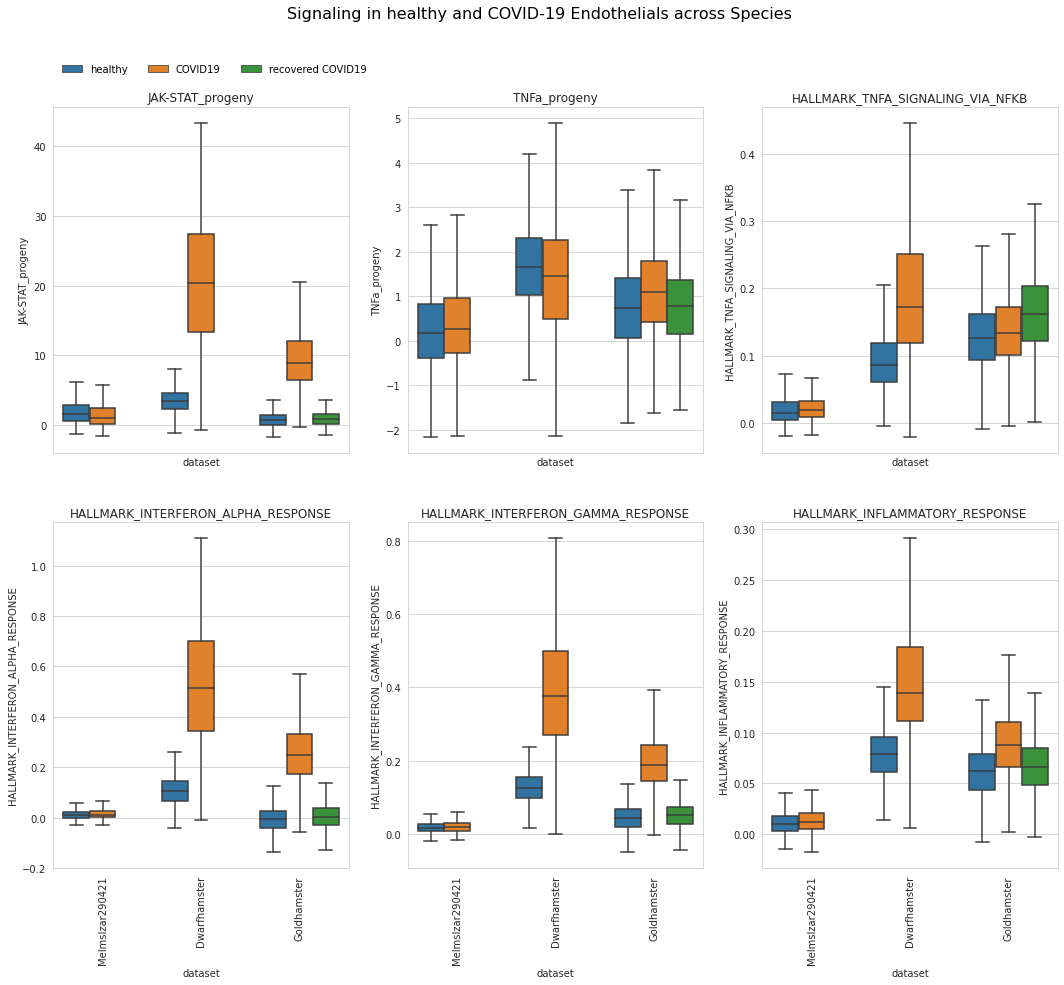

In [59]:
# Endos
sdf = df[df.celltype.isin(['Bronchial', 'Capillary', 'Artery', 'Vein', 'Lymphatic', 'Endothelial cells'])]

hm_keys = ['HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_INFLAMMATORY_RESPONSE']
keys = ['JAK-STAT_progeny', 'TNFa_progeny'] + hm_keys

with sns.axes_style('whitegrid'):
#     fig, axs = pl.subplots(1,len(keys), figsize=[6*len(keys), 7])
    fig, axs = pl.subplots(2,int(len(keys)/2), figsize=[6*len(keys)/2, 7*2], sharex=True)
    axs = np.ravel(axs)
for key, ax in zip(keys, axs):
    sns.boxplot(data=sdf, x='dataset', y=key, showfliers=False, ax=ax, hue='disease')
    ax.set_title(key)
    if ax!=axs[0]:
        ax.get_legend().remove()
    else:
        sns.move_legend(ax, loc='upper right')#, bbox_to_anchor=(1, 1))
    ax.set_title(key)
    ax.tick_params(axis='x', labelrotation=90)

sns.move_legend(
    axs[0], "lower left",
    bbox_to_anchor=(0, 1.07), ncol=3, title=None, frameon=False,
)
pl.suptitle('Signaling in healthy and COVID-19 Endothelials across Species', fontsize=16)
    
pl.show()

# deseq2 results (test COVID-19 infected vs healthy)

In [4]:
def load_deseq(celltype):
    dfs = []
    for key in ['dwarf_ld', 'dwarf_hd', 'gold']:
        fname = f"/fast/scratch/users/peidlis_c/{celltype}_{key}_disease.csv"
        if os.path.isfile(fname): 
            tab_ham = pd.read_csv(fname, index_col=0)
            tab_ham.index = specify_genes(tab_ham.index)
            tab_ham = tab_ham[~tab_ham.index.duplicated(keep='first')]
            tab_ham.columns = [c+'_'+key for c in tab_ham.columns]
            dfs.append(tab_ham)
    
    for key in ['LiaoZhang', 'MelmsIzar', 'ChuaEils']:
        fname = f"/fast/scratch/users/peidlis_c/{celltype}_{key}_disease.csv"
        if os.path.isfile(fname):
            t = pd.read_csv(fname, index_col=0)
            t.columns = [c+'_'+key for c in t.columns]
            dfs.append(t)

    degs = pd.concat(dfs, axis=1)
    return degs

In [5]:
celltype='Endothelial'
degs = load_deseq(celltype)
# degs = load_deseq('')


ifng_genes = ['STAT1', 'ISG15', 'IFIT1', 'MX1', 'IFIT3', 'IFI35', 'IRF7', 'IFIT2', 'OAS2', 'TAP1', 'EIF2AK2', 'RSAD2', 'MX2', 'IRF1', 'OAS3', 'TNFSF10', 'IRF9', 'CXCL10', 'IFI44', 'BST2', 'XAF1', 'SP110', 'OASL', 'PSMB8', 'IFI44L', 'IFITM3', 'DDX60', 'LGALS3BP', 'GBP4', 'IRF8', 'PSMB9', 'PML', 'IFIH1', 'UBE2L6', 'IFI27', 'ADAR', 'LY6E', 'STAT2', 'CXCL9', 'IL10RA', 'PLA2G4A', 'TRIM21', 'USP18', 'PTGS2', 'EPSTI1', 'C1S', 'DDX58', 'IL15', 'NLRC5', 'NMI', 'IDO1', 'PSMB10', 'CXCL11', 'ITGB7', 'SAMHD1', 'HERC6', 'CMPK2', 'SAMD9L', 'RTP4', 'PTPN2', 'PARP14', 'TNFAIP2', 'IFITM2', 'PLSCR1', 'SOCS1', 'CASP1', 'ICAM1', 'WARS', 'PSME1', 'ISG20', 'IRF2', 'TRIM14', 'FCGR1A', 'MARCH1', 'SOCS3', 'JAK2', 'HLA-DMA', 'PARP12', 'TNFAIP6', 'TRIM26', 'VCAM1', 'CD274', 'CIITA', 'NAMPT', 'SELP', 'GPR18', 'FPR1', 'PRIC285', 'PSME2', 'SERPING1', 'CCL5', 'RNF31', 'SOD2', 'TRIM25', 'LAP3', 'PSMA3', 'RNF213', 'PELI1', 'CFB', 'CD86', 'TXNIP', 'HLA-DQA1', 'GCH1', 'PNP', 'CCL7', 'PTPN6', 'SPPL2A', 'IL4R', 'PNPT1', 'DHX58', 'BTG1', 'CASP8', 'IFI30', 'CCL2', 'FGL2', 'CASP7', 'SECTM1', 'IL15RA', 'CD40', 'TRAFD1', 'HLA-DRB1', 'GBP6', 'LCP2', 'HLA-G', 'MT2A', 'RIPK1', 'KLRK1', 'UPP1', 'PSMB2', 'TDRD7', 'HIF1A', 'EIF4E3', 'VAMP8', 'PFKP', 'CD38', 'ZBP1', 'BANK1', 'TOR1B', 'RBCK1', 'PDE4B', 'MVP', 'IL7', 'BPGM', 'FTSJD2', 'AUTS2', 'B2M', 'RIPK2', 'CD69', 'MYD88', 'PSMA2', 'PIM1', 'NOD1', 'CFH', 'TAPBP', 'SLC25A28', 'PTPN1', 'TNFAIP3', 'SSPN', 'NUP93', 'MTHFD2', 'CDKN1A', 'IRF4', 'NFKB1', 'BATF2', 'HLA-B', 'LATS2', 'IRF5', 'SLAMF7', 'ISOC1', 'P2RY14', 'STAT3', 'NCOA3', 'HLA-A', 'IL6', 'GZMA', 'IFNAR2', 'CD74', 'RAPGEF6', 'CASP4', 'FAS', 'OGFR', 'ARL4A', 'SRI', 'LYSMD2', 'CSF2RB', 'ST3GAL5', 'C1R', 'CASP3', 'CMKLR1', 'NFKBIA', 'METTL7B', 'ST8SIA4', 'XCL1', 'IL2RB', 'VAMP5', 'IL18BP', 'ZNFX1', 'ARID5B', 'APOL6', 'STAT4']
degs['ifng_gene'] = 'False'
degs['ifng_gene'][degs.index.isin(ifng_genes)] = 'True'

In [44]:
# nice
degs.loc[['ISG15', 'ISG20', 'RSAD2', 'MX1', 'IFIT3', 'IFIT1', 'STAT1', 'SOCS1']][[c for c in degs.columns if 'log2FoldChange' in c]]

,log2FoldChange_dwarf_ld,log2FoldChange_dwarf_hd,log2FoldChange_gold,log2FoldChange_MelmsIzar
ISG15,5.105376,6.709249,4.943381,1.513115
ISG20,1.891823,3.628733,1.744653,0.243073
RSAD2,4.333555,7.488052,6.497857,0.306690
MX1,5.450630,6.401296,4.996199,-0.527751
IFIT3,3.560831,4.973762,5.710066,-0.157911
IFIT1,NaN,NaN,2.043225,1.045570
STAT1,1.246964,0.984172,1.839560,-0.185062
SOCS1,1.985899,4.063053,2.402675,NaN


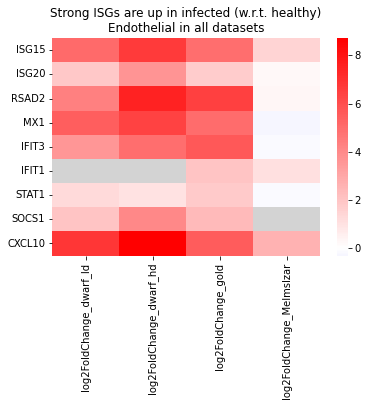

In [49]:
sdegs = degs.loc[['ISG15', 'ISG20', 'RSAD2', 'MX1', 'IFIT3', 'IFIT1', 'STAT1', 'SOCS1', 'CXCL10']][[c for c in degs.columns if 'log2FoldChange' in c]]
g=sns.heatmap(sdegs, center=0, cmap='bwr', robust=True, mask=pd.isna(sdegs))
g.set_facecolor('lightgrey')
pl.title(f'Strong ISGs are up in infected (w.r.t. healthy)\n{celltype} in all datasets')
pl.show()

In [253]:
celltype='Macrophages'
degs = load_deseq(celltype)
ifng_genes = ['STAT1', 'ISG15', 'IFIT1', 'MX1', 'IFIT3', 'IFI35', 'IRF7', 'IFIT2', 'OAS2', 'TAP1', 'EIF2AK2', 'RSAD2', 'MX2', 'IRF1', 'OAS3', 'TNFSF10', 'IRF9', 'CXCL10', 'IFI44', 'BST2', 'XAF1', 'SP110', 'OASL', 'PSMB8', 'IFI44L', 'IFITM3', 'DDX60', 'LGALS3BP', 'GBP4', 'IRF8', 'PSMB9', 'PML', 'IFIH1', 'UBE2L6', 'IFI27', 'ADAR', 'LY6E', 'STAT2', 'CXCL9', 'IL10RA', 'PLA2G4A', 'TRIM21', 'USP18', 'PTGS2', 'EPSTI1', 'C1S', 'DDX58', 'IL15', 'NLRC5', 'NMI', 'IDO1', 'PSMB10', 'CXCL11', 'ITGB7', 'SAMHD1', 'HERC6', 'CMPK2', 'SAMD9L', 'RTP4', 'PTPN2', 'PARP14', 'TNFAIP2', 'IFITM2', 'PLSCR1', 'SOCS1', 'CASP1', 'ICAM1', 'WARS', 'PSME1', 'ISG20', 'IRF2', 'TRIM14', 'FCGR1A', 'MARCH1', 'SOCS3', 'JAK2', 'HLA-DMA', 'PARP12', 'TNFAIP6', 'TRIM26', 'VCAM1', 'CD274', 'CIITA', 'NAMPT', 'SELP', 'GPR18', 'FPR1', 'PRIC285', 'PSME2', 'SERPING1', 'CCL5', 'RNF31', 'SOD2', 'TRIM25', 'LAP3', 'PSMA3', 'RNF213', 'PELI1', 'CFB', 'CD86', 'TXNIP', 'HLA-DQA1', 'GCH1', 'PNP', 'CCL7', 'PTPN6', 'SPPL2A', 'IL4R', 'PNPT1', 'DHX58', 'BTG1', 'CASP8', 'IFI30', 'CCL2', 'FGL2', 'CASP7', 'SECTM1', 'IL15RA', 'CD40', 'TRAFD1', 'HLA-DRB1', 'GBP6', 'LCP2', 'HLA-G', 'MT2A', 'RIPK1', 'KLRK1', 'UPP1', 'PSMB2', 'TDRD7', 'HIF1A', 'EIF4E3', 'VAMP8', 'PFKP', 'CD38', 'ZBP1', 'BANK1', 'TOR1B', 'RBCK1', 'PDE4B', 'MVP', 'IL7', 'BPGM', 'FTSJD2', 'AUTS2', 'B2M', 'RIPK2', 'CD69', 'MYD88', 'PSMA2', 'PIM1', 'NOD1', 'CFH', 'TAPBP', 'SLC25A28', 'PTPN1', 'TNFAIP3', 'SSPN', 'NUP93', 'MTHFD2', 'CDKN1A', 'IRF4', 'NFKB1', 'BATF2', 'HLA-B', 'LATS2', 'IRF5', 'SLAMF7', 'ISOC1', 'P2RY14', 'STAT3', 'NCOA3', 'HLA-A', 'IL6', 'GZMA', 'IFNAR2', 'CD74', 'RAPGEF6', 'CASP4', 'FAS', 'OGFR', 'ARL4A', 'SRI', 'LYSMD2', 'CSF2RB', 'ST3GAL5', 'C1R', 'CASP3', 'CMKLR1', 'NFKBIA', 'METTL7B', 'ST8SIA4', 'XCL1', 'IL2RB', 'VAMP5', 'IL18BP', 'ZNFX1', 'ARID5B', 'APOL6', 'STAT4']
degs['ifng_gene'] = 'False'
degs['ifng_gene'][degs.index.isin(ifng_genes)] = 'True'

In [254]:
mask = ~pd.isna(degs[[c for c in degs.columns if 'log2FoldChange' in c]]).any(axis=1)
avg_l2fc = degs.loc[degs.index[mask], [c for c in degs.columns if 'log2FoldChange' in c]].mean(axis=1).sort_values(ascending=False)

In [255]:
n_top = 20
sdegs = degs.loc[avg_l2fc.index[:n_top], [c for c in degs.columns if 'log2FoldChange' in c]]
sdegs.columns = [x.replace('log2FoldChange_', '') for x in sdegs.columns]

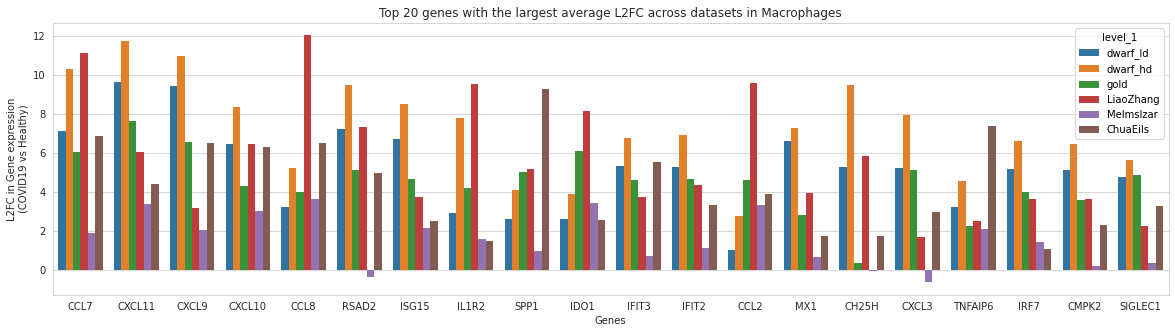

In [266]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[20, 5])
sns.barplot(data=sdegs.stack().reset_index(), x='level_0', y=0, hue='level_1', ax=ax)
ax.set_title(f'Top {n_top} genes with the largest average L2FC across datasets in {celltype}')
ax.set_xlabel('Genes')
ax.set_ylabel('L2FC in Gene expression\n(COVID19 vs Healthy)')
pl.savefig(f'{figure_path}Top20_L2FC_across_datasets_Macros_infection_barplot.pdf')
pl.show()

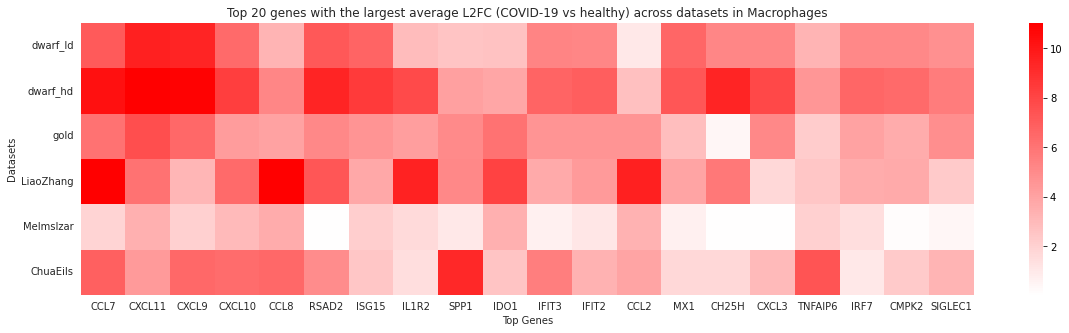

In [265]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[20, 5])
sns.heatmap(data=sdegs.T, ax=ax, cmap='bwr', center=0, robust=True)
ax.set_title(f'Top {n_top} genes with the largest average L2FC (COVID-19 vs healthy) across datasets in {celltype}')
ax.set_xlabel('Top Genes')
ax.set_ylabel('Datasets')
pl.savefig(f'{figure_path}Top20_L2FC_across_datasets_Macros_infection_heatmap.pdf')
pl.show()

In [186]:
genes = sdegs.index
gseapy_enrichr(genes, degs.index, min_genes=8)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes,members
0,CUSTOM22865574865216,HALLMARK_INTERFERON_GAMMA_RESPONSE,14/199,2.277505e-27,3.416257e-26,363.145749,TNFAIP6;CXCL11;CMPK2;IFIT2;CXCL10;CXCL9;ISG15;...,14
1,CUSTOM22865574865216,HALLMARK_INTERFERON_ALPHA_RESPONSE,9/97,1.999799e-18,1.499849e-17,276.027425,CXCL11;CMPK2;IFIT2;CXCL10;ISG15;IRF7;IFIT3;RSA...,9
2,CUSTOM22865574297472,KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION,8/241,9.097555e-13,1.273658e-11,91.326957,IL1R2;CXCL11;CCL8;CXCL10;CXCL9;CCL2;CXCL3;CCL7,8
3,CUSTOM22865574303488,REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM,9/686,1.027785e-10,2.158348e-09,38.493968,IL1R2;IFIT2;CXCL10;ISG15;IRF7;IFIT3;RSAD2;CCL2...,9


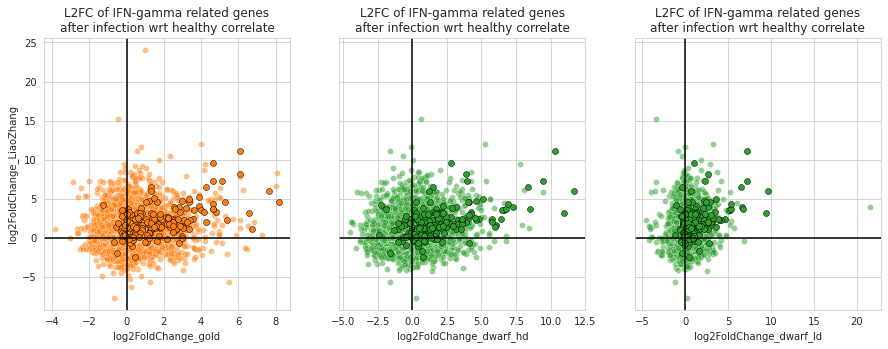

In [188]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1,3, figsize=[5*3, 5], sharey=True)
key = 'log2FoldChange'

for ax, org in zip(axs, ['gold', 'dwarf_hd', 'dwarf_ld']):
    color = 'tab:green' if 'dwarf' in org else 'tab:orange'
    sns.scatterplot(data=degs[degs.ifng_gene=='False'], y=f'{key}_LiaoZhang', x=f'{key}_{org}', ax=ax, alpha=0.5, color=color)
    sns.scatterplot(data=degs[degs.ifng_gene=='True'], y=f'{key}_LiaoZhang', x=f'{key}_{org}', ax=ax, color=color, edgecolor='k')
    ax.axvline(0, c='k')
    ax.axhline(0, c='k')
    ax.set_title('L2FC of IFN-gamma related genes\nafter infection wrt healthy correlate')
pl.show()

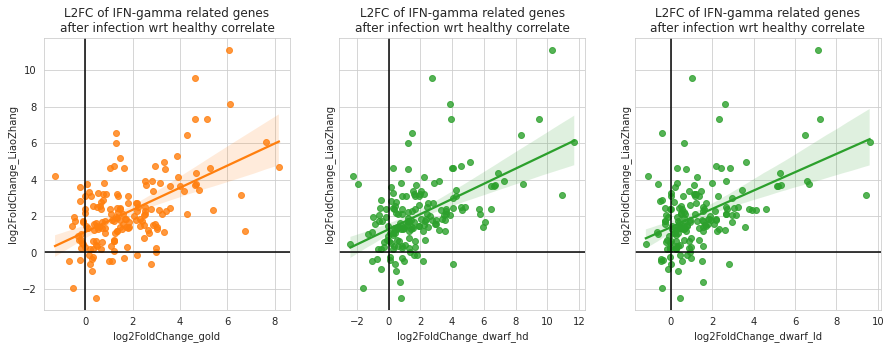

In [189]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1,3, figsize=[5*3, 5], sharey=True)
key = 'log2FoldChange'

for ax, org in zip(axs, ['gold', 'dwarf_hd', 'dwarf_ld']):
    color = 'tab:green' if 'dwarf' in org else 'tab:orange'
    sns.regplot(data=degs[degs.ifng_gene=='True'], y=f'{key}_LiaoZhang', x=f'{key}_{org}', ax=ax, color=color)
    ax.axvline(0, c='k')
    ax.axhline(0, c='k')
    ax.set_title('L2FC of IFN-gamma related genes\nafter infection wrt healthy correlate')
pl.show()

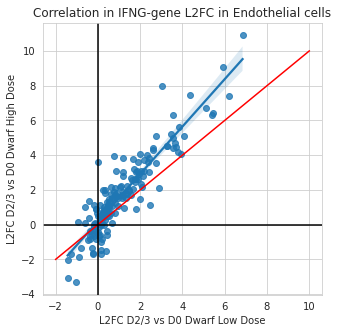

In [15]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(1,1, figsize=[5, 5])
key = 'log2FoldChange'

sns.regplot(data=degs[degs.ifng_gene=='True'], y=f'{key}_dwarf_hd', x=f'{key}_dwarf_ld', ax=ax, color='tab:blue')
ax.plot([-2,10], [-2,10], c='r')
ax.axvline(0, c='k')
ax.axhline(0, c='k')
ax.set_title('Correlation in IFNG-gene L2FC in Endothelial cells')
ax.set_ylabel('L2FC D2/3 vs D0 Dwarf High Dose')
ax.set_xlabel('L2FC D2/3 vs D0 Dwarf Low Dose')
pl.savefig(f'{figure_path}HDvsLD_dwarf_l2fc.pdf')
pl.show()

In [230]:
celltype='Endothelial'
degs = load_deseq(celltype)
# degs = load_deseq('')


ifng_genes = ['STAT1', 'ISG15', 'IFIT1', 'MX1', 'IFIT3', 'IFI35', 'IRF7', 'IFIT2', 'OAS2', 'TAP1', 'EIF2AK2', 'RSAD2', 'MX2', 'IRF1', 'OAS3', 'TNFSF10', 'IRF9', 'CXCL10', 'IFI44', 'BST2', 'XAF1', 'SP110', 'OASL', 'PSMB8', 'IFI44L', 'IFITM3', 'DDX60', 'LGALS3BP', 'GBP4', 'IRF8', 'PSMB9', 'PML', 'IFIH1', 'UBE2L6', 'IFI27', 'ADAR', 'LY6E', 'STAT2', 'CXCL9', 'IL10RA', 'PLA2G4A', 'TRIM21', 'USP18', 'PTGS2', 'EPSTI1', 'C1S', 'DDX58', 'IL15', 'NLRC5', 'NMI', 'IDO1', 'PSMB10', 'CXCL11', 'ITGB7', 'SAMHD1', 'HERC6', 'CMPK2', 'SAMD9L', 'RTP4', 'PTPN2', 'PARP14', 'TNFAIP2', 'IFITM2', 'PLSCR1', 'SOCS1', 'CASP1', 'ICAM1', 'WARS', 'PSME1', 'ISG20', 'IRF2', 'TRIM14', 'FCGR1A', 'MARCH1', 'SOCS3', 'JAK2', 'HLA-DMA', 'PARP12', 'TNFAIP6', 'TRIM26', 'VCAM1', 'CD274', 'CIITA', 'NAMPT', 'SELP', 'GPR18', 'FPR1', 'PRIC285', 'PSME2', 'SERPING1', 'CCL5', 'RNF31', 'SOD2', 'TRIM25', 'LAP3', 'PSMA3', 'RNF213', 'PELI1', 'CFB', 'CD86', 'TXNIP', 'HLA-DQA1', 'GCH1', 'PNP', 'CCL7', 'PTPN6', 'SPPL2A', 'IL4R', 'PNPT1', 'DHX58', 'BTG1', 'CASP8', 'IFI30', 'CCL2', 'FGL2', 'CASP7', 'SECTM1', 'IL15RA', 'CD40', 'TRAFD1', 'HLA-DRB1', 'GBP6', 'LCP2', 'HLA-G', 'MT2A', 'RIPK1', 'KLRK1', 'UPP1', 'PSMB2', 'TDRD7', 'HIF1A', 'EIF4E3', 'VAMP8', 'PFKP', 'CD38', 'ZBP1', 'BANK1', 'TOR1B', 'RBCK1', 'PDE4B', 'MVP', 'IL7', 'BPGM', 'FTSJD2', 'AUTS2', 'B2M', 'RIPK2', 'CD69', 'MYD88', 'PSMA2', 'PIM1', 'NOD1', 'CFH', 'TAPBP', 'SLC25A28', 'PTPN1', 'TNFAIP3', 'SSPN', 'NUP93', 'MTHFD2', 'CDKN1A', 'IRF4', 'NFKB1', 'BATF2', 'HLA-B', 'LATS2', 'IRF5', 'SLAMF7', 'ISOC1', 'P2RY14', 'STAT3', 'NCOA3', 'HLA-A', 'IL6', 'GZMA', 'IFNAR2', 'CD74', 'RAPGEF6', 'CASP4', 'FAS', 'OGFR', 'ARL4A', 'SRI', 'LYSMD2', 'CSF2RB', 'ST3GAL5', 'C1R', 'CASP3', 'CMKLR1', 'NFKBIA', 'METTL7B', 'ST8SIA4', 'XCL1', 'IL2RB', 'VAMP5', 'IL18BP', 'ZNFX1', 'ARID5B', 'APOL6', 'STAT4']
degs['ifng_gene'] = 'False'
degs['ifng_gene'][degs.index.isin(ifng_genes)] = 'True'

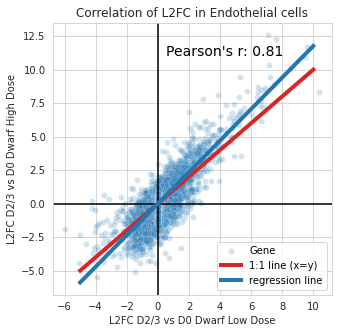

In [251]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(1,1, figsize=[5, 5])
key = 'log2FoldChange'

x = degs[degs[f'{key}_dwarf_ld']<20][f'{key}_dwarf_ld']
y = degs[degs[f'{key}_dwarf_ld']<20][f'{key}_dwarf_hd']
sns.scatterplot(data=degs[degs[f'{key}_dwarf_ld']<20], y=y, x=x, ax=ax, color='tab:blue', alpha=0.2, label='Gene')

# regression
mask = ~pd.isna(x) & ~pd.isna(y)
a, _, _, _ = np.linalg.lstsq(x[mask,np.newaxis], y[mask])
r, p = pearsonr(x[mask], y[mask])
ax.text(.5, 11, f"Pearson's r: {np.round(r,2)}", fontsize=14)

ax.axvline(0, c='k')
ax.axhline(0, c='k')
ax.set_title('Correlation of L2FC in Endothelial cells')
ax.set_ylabel('L2FC D2/3 vs D0 Dwarf High Dose')
ax.set_xlabel('L2FC D2/3 vs D0 Dwarf Low Dose')

x_min = -5
x_max = 10
ax.plot([x_min, x_max], [x_min, x_max], c='tab:red', linewidth=4, label='1:1 line (x=y)')
ax.plot([x_min, x_max], [x_min * a, x_max * a], c='tab:blue', linewidth=4, label='regression line')
pl.legend()

pl.savefig(f'{figure_path}HDvsLD_dwarf_l2fc_all.pdf')
pl.show()

In [245]:
celltype='Macrophages'
degs = load_deseq(celltype)

ifng_genes = ['STAT1', 'ISG15', 'IFIT1', 'MX1', 'IFIT3', 'IFI35', 'IRF7', 'IFIT2', 'OAS2', 'TAP1', 'EIF2AK2', 'RSAD2', 'MX2', 'IRF1', 'OAS3', 'TNFSF10', 'IRF9', 'CXCL10', 'IFI44', 'BST2', 'XAF1', 'SP110', 'OASL', 'PSMB8', 'IFI44L', 'IFITM3', 'DDX60', 'LGALS3BP', 'GBP4', 'IRF8', 'PSMB9', 'PML', 'IFIH1', 'UBE2L6', 'IFI27', 'ADAR', 'LY6E', 'STAT2', 'CXCL9', 'IL10RA', 'PLA2G4A', 'TRIM21', 'USP18', 'PTGS2', 'EPSTI1', 'C1S', 'DDX58', 'IL15', 'NLRC5', 'NMI', 'IDO1', 'PSMB10', 'CXCL11', 'ITGB7', 'SAMHD1', 'HERC6', 'CMPK2', 'SAMD9L', 'RTP4', 'PTPN2', 'PARP14', 'TNFAIP2', 'IFITM2', 'PLSCR1', 'SOCS1', 'CASP1', 'ICAM1', 'WARS', 'PSME1', 'ISG20', 'IRF2', 'TRIM14', 'FCGR1A', 'MARCH1', 'SOCS3', 'JAK2', 'HLA-DMA', 'PARP12', 'TNFAIP6', 'TRIM26', 'VCAM1', 'CD274', 'CIITA', 'NAMPT', 'SELP', 'GPR18', 'FPR1', 'PRIC285', 'PSME2', 'SERPING1', 'CCL5', 'RNF31', 'SOD2', 'TRIM25', 'LAP3', 'PSMA3', 'RNF213', 'PELI1', 'CFB', 'CD86', 'TXNIP', 'HLA-DQA1', 'GCH1', 'PNP', 'CCL7', 'PTPN6', 'SPPL2A', 'IL4R', 'PNPT1', 'DHX58', 'BTG1', 'CASP8', 'IFI30', 'CCL2', 'FGL2', 'CASP7', 'SECTM1', 'IL15RA', 'CD40', 'TRAFD1', 'HLA-DRB1', 'GBP6', 'LCP2', 'HLA-G', 'MT2A', 'RIPK1', 'KLRK1', 'UPP1', 'PSMB2', 'TDRD7', 'HIF1A', 'EIF4E3', 'VAMP8', 'PFKP', 'CD38', 'ZBP1', 'BANK1', 'TOR1B', 'RBCK1', 'PDE4B', 'MVP', 'IL7', 'BPGM', 'FTSJD2', 'AUTS2', 'B2M', 'RIPK2', 'CD69', 'MYD88', 'PSMA2', 'PIM1', 'NOD1', 'CFH', 'TAPBP', 'SLC25A28', 'PTPN1', 'TNFAIP3', 'SSPN', 'NUP93', 'MTHFD2', 'CDKN1A', 'IRF4', 'NFKB1', 'BATF2', 'HLA-B', 'LATS2', 'IRF5', 'SLAMF7', 'ISOC1', 'P2RY14', 'STAT3', 'NCOA3', 'HLA-A', 'IL6', 'GZMA', 'IFNAR2', 'CD74', 'RAPGEF6', 'CASP4', 'FAS', 'OGFR', 'ARL4A', 'SRI', 'LYSMD2', 'CSF2RB', 'ST3GAL5', 'C1R', 'CASP3', 'CMKLR1', 'NFKBIA', 'METTL7B', 'ST8SIA4', 'XCL1', 'IL2RB', 'VAMP5', 'IL18BP', 'ZNFX1', 'ARID5B', 'APOL6', 'STAT4']
degs['ifng_gene'] = 'False'
degs['ifng_gene'][degs.index.isin(ifng_genes)] = 'True'

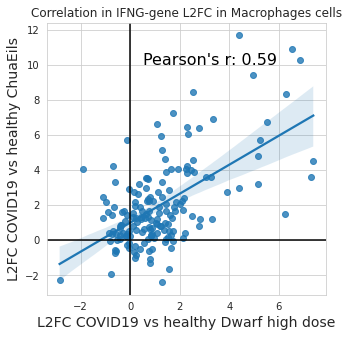

In [250]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(1,1, figsize=[5, 5])
key = 'log2FoldChange'

x = degs[degs.ifng_gene=='True'][f'{key}_ChuaEils']
y = degs[degs.ifng_gene=='True'][f'{key}_dwarf_hd']
sns.regplot(data=degs[degs.ifng_gene=='True'], y=y, x=x, ax=ax, color='tab:blue')

mask = ~x.isna() & ~y.isna()
corr, pv = pearsonr(x[mask], y[mask])

ax.text(.5,10,f"Pearson's r: {np.round(corr,2)}", fontsize=16)

ax.axvline(0, c='k')
ax.axhline(0, c='k')
ax.set_title('Correlation in IFNG-gene L2FC in Macrophages cells')
ax.set_ylabel('L2FC COVID19 vs healthy ChuaEils', fontsize=14)
ax.set_xlabel('L2FC COVID19 vs healthy Dwarf high dose', fontsize=14)
pl.savefig(f'{figure_path}L2FC_Macros_example_correlation.pdf')
pl.show()

In [53]:
celltype='Macrophages'
degs = load_deseq(celltype)

ifng_genes = ['STAT1', 'ISG15', 'IFIT1', 'MX1', 'IFIT3', 'IFI35', 'IRF7', 'IFIT2', 'OAS2', 'TAP1', 'EIF2AK2', 'RSAD2', 'MX2', 'IRF1', 'OAS3', 'TNFSF10', 'IRF9', 'CXCL10', 'IFI44', 'BST2', 'XAF1', 'SP110', 'OASL', 'PSMB8', 'IFI44L', 'IFITM3', 'DDX60', 'LGALS3BP', 'GBP4', 'IRF8', 'PSMB9', 'PML', 'IFIH1', 'UBE2L6', 'IFI27', 'ADAR', 'LY6E', 'STAT2', 'CXCL9', 'IL10RA', 'PLA2G4A', 'TRIM21', 'USP18', 'PTGS2', 'EPSTI1', 'C1S', 'DDX58', 'IL15', 'NLRC5', 'NMI', 'IDO1', 'PSMB10', 'CXCL11', 'ITGB7', 'SAMHD1', 'HERC6', 'CMPK2', 'SAMD9L', 'RTP4', 'PTPN2', 'PARP14', 'TNFAIP2', 'IFITM2', 'PLSCR1', 'SOCS1', 'CASP1', 'ICAM1', 'WARS', 'PSME1', 'ISG20', 'IRF2', 'TRIM14', 'FCGR1A', 'MARCH1', 'SOCS3', 'JAK2', 'HLA-DMA', 'PARP12', 'TNFAIP6', 'TRIM26', 'VCAM1', 'CD274', 'CIITA', 'NAMPT', 'SELP', 'GPR18', 'FPR1', 'PRIC285', 'PSME2', 'SERPING1', 'CCL5', 'RNF31', 'SOD2', 'TRIM25', 'LAP3', 'PSMA3', 'RNF213', 'PELI1', 'CFB', 'CD86', 'TXNIP', 'HLA-DQA1', 'GCH1', 'PNP', 'CCL7', 'PTPN6', 'SPPL2A', 'IL4R', 'PNPT1', 'DHX58', 'BTG1', 'CASP8', 'IFI30', 'CCL2', 'FGL2', 'CASP7', 'SECTM1', 'IL15RA', 'CD40', 'TRAFD1', 'HLA-DRB1', 'GBP6', 'LCP2', 'HLA-G', 'MT2A', 'RIPK1', 'KLRK1', 'UPP1', 'PSMB2', 'TDRD7', 'HIF1A', 'EIF4E3', 'VAMP8', 'PFKP', 'CD38', 'ZBP1', 'BANK1', 'TOR1B', 'RBCK1', 'PDE4B', 'MVP', 'IL7', 'BPGM', 'FTSJD2', 'AUTS2', 'B2M', 'RIPK2', 'CD69', 'MYD88', 'PSMA2', 'PIM1', 'NOD1', 'CFH', 'TAPBP', 'SLC25A28', 'PTPN1', 'TNFAIP3', 'SSPN', 'NUP93', 'MTHFD2', 'CDKN1A', 'IRF4', 'NFKB1', 'BATF2', 'HLA-B', 'LATS2', 'IRF5', 'SLAMF7', 'ISOC1', 'P2RY14', 'STAT3', 'NCOA3', 'HLA-A', 'IL6', 'GZMA', 'IFNAR2', 'CD74', 'RAPGEF6', 'CASP4', 'FAS', 'OGFR', 'ARL4A', 'SRI', 'LYSMD2', 'CSF2RB', 'ST3GAL5', 'C1R', 'CASP3', 'CMKLR1', 'NFKBIA', 'METTL7B', 'ST8SIA4', 'XCL1', 'IL2RB', 'VAMP5', 'IL18BP', 'ZNFX1', 'ARID5B', 'APOL6', 'STAT4']
degs['ifng_gene'] = 'False'
degs['ifng_gene'][degs.index.isin(ifng_genes)] = 'True'

In [204]:
# Generally quite high correlation
# hamster of course stronger
# should to this for Dwarf and Gold separately
from scipy.stats import pearsonr
sdegs = degs[degs.ifng_gene=='True']
ckeys = [c for c in degs.columns if 'log2FoldChange' in c]
A = pd.DataFrame(index=ckeys, columns=ckeys, dtype=float)
B = pd.DataFrame(index=ckeys, columns=ckeys, dtype=float)
for ckey in ckeys:
    for ckey_ in ckeys:
        x = sdegs[ckey]
        y = sdegs[ckey_]
        mask = ~x.isna() & ~y.isna()
        corr, pv = pearsonr(x[mask], y[mask])
        A.loc[ckey, ckey_] = corr
        B.loc[ckey, ckey_] = pv
A = cluster_matrix(A, 'both')
B = B.loc[A.index, A.columns]
B = -np.log10(B)
B[B==np.infty] = None

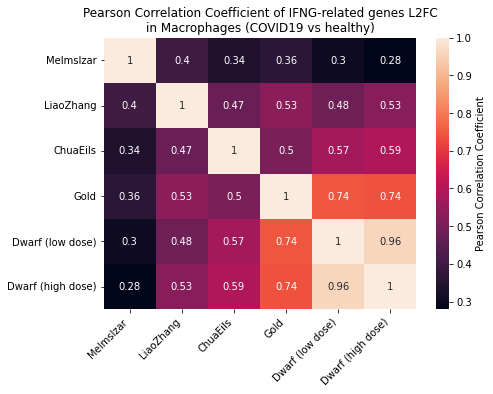

In [208]:
A.index = [a.split('_', 1)[-1] for a in A.index]
A.rename(index={'gold': 'Gold', 'dwarf_ld': 'Dwarf (low dose)', 'dwarf_hd': 'Dwarf (high dose)'}, inplace=True)
A.columns = A.index

fig, ax = pl.subplots(figsize=[7,5])
g = sns.heatmap(A, annot=True, cbar_kws={'label': "Pearson Correlation Coefficient"}, ax=ax)
ax.set_title('Pearson Correlation Coefficient of IFNG-related genes L2FC\nin Macrophages (COVID19 vs healthy)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, va='top', ha='right')
pl.savefig(f'{figure_path}Correlation_Macro_IFNG_L2FC.pdf')
pl.show()

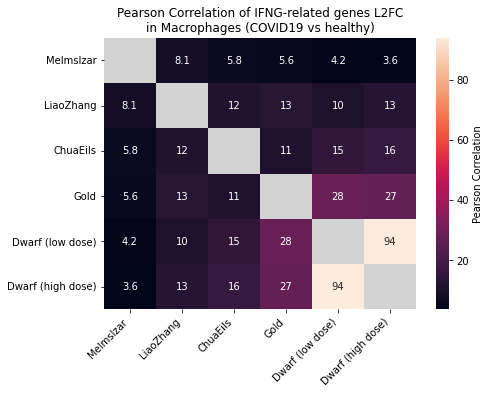

In [207]:
B.index = [a.split('_', 1)[-1] for a in B.index]
B.rename(index={'gold': 'Gold', 'dwarf_ld': 'Dwarf (low dose)', 'dwarf_hd': 'Dwarf (high dose)'}, inplace=True)
B.columns = B.index

fig, ax = pl.subplots(figsize=[7,5])
g = sns.heatmap(B, annot=True, cbar_kws={'label': "Pearson Correlation"}, ax=ax)
ax.set_title('Pearson Correlation of IFNG-related genes L2FC\nin Macrophages (COVID19 vs healthy)')
g.set_facecolor('lightgrey')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, va='top', ha='right')
# pl.savefig(f'{figure_path}Correlation_Macro_IFNG_L2FC.pdf')
pl.show()

# New plots

In [38]:
bdata.obs['temp'] = [f'{o}_healthy' if t=='D0' else f'{o}_recovered' if t=='E14' else f'{o}_infected' for t, o in zip(bdata.obs.time, bdata.obs.organism)]
ChuaEils290620_data.obs['temp'] = [f'Chua_{s}' for s in ChuaEils290620_data.obs.severity]
LiaoZhang120520_data.obs['temp'] = [f'Liao_{s}' for s in LiaoZhang120520_data.obs.severity]
MelmsIzar290421_data.obs['temp'] = [f'Melms_{s}' for s in MelmsIzar290421_data.obs.severity]

In [ ]:
groupby = 'celltype'
hue = 'temp'
df = pd.concat([bdata.obs, ChuaEils290620_data.obs, LiaoZhang120520_data.obs, MelmsIzar290421_data.obs], axis=0)

In [54]:
# unify celltype annotations
df['celltype'] = df['celltype'].astype(str)
for ct in ['Bronchial', 'Capillary', 'Artery', 'Vein', 'Lymphatic']:
    df['celltype'][df['celltype']==ct] = 'Endothelial cells'
for ct in ['InterstitialMacrophages', 'MonocyticMacrophages', 'Treml4+Macrophages', 'AlveolarMacrophages', 'Monocytes']:
    df['celltype'][df['celltype']==ct] = 'Macrophages'
for ct in ['Tuft-like', 'Ciliated', 'Epithelial', 'AT1', 'AT2']:
    df['celltype'][df['celltype']==ct] = 'Epithelial cells'
df = df[~df.celltype.str.startswith('unclear')]
df = df[~df.celltype.str.startswith('mixed')]
df = df[~df.celltype.isin(['Plasma cells', 'Pericytes', 'Mast cells', 'Neuronal cells', 'Plasma', 'MC', 'Mast', 'nan'])]
df = df[df.celltype.isin(['Epithelial cells', 'Bcells', 'MyeloidDendritic', 'TNKcells', 'pDC', 'Macrophages', 'Neutrophils', 'Endothelial cells'])]

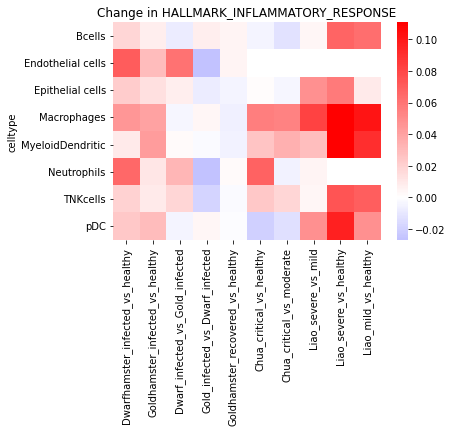

In [125]:
key = 'HALLMARK_INFLAMMATORY_RESPONSE'
fc = pd.DataFrame({
    'Dwarfhamster_infected_vs_healthy' : df[df.temp=='Dwarfhamster_infected'].groupby(groupby).mean()[key] - df[df.temp=='Dwarfhamster_healthy'].groupby(groupby).mean()[key],
    'Goldhamster_infected_vs_healthy' : df[df.temp=='Goldhamster_infected'].groupby(groupby).mean()[key] - df[df.temp=='Goldhamster_healthy'].groupby(groupby).mean()[key],
    'Dwarf_infected_vs_Gold_infected' : df[df.temp=='Dwarfhamster_infected'].groupby(groupby).mean()[key] - df[(df.temp=='Goldhamster_infected') & (df.time!='D5')].groupby(groupby).mean()[key],
    'Gold_infected_vs_Dwarf_infected' : df[(df.temp=='Goldhamster_infected') & (df.time!='D5')].groupby(groupby).mean()[key] - df[df.temp=='Dwarfhamster_infected'].groupby(groupby).mean()[key],
    'Goldhamster_recovered_vs_healthy' : df[df.temp=='Goldhamster_recovered'].groupby(groupby).mean()[key] - df[df.temp=='Goldhamster_healthy'].groupby(groupby).mean()[key],
    'Chua_critical_vs_healthy' : df[df.temp=='Chua_critical'].groupby(groupby).mean()[key] - df[df.temp=='Chua_control'].groupby(groupby).mean()[key],
    'Chua_critical_vs_moderate' : df[df.temp=='Chua_critical'].groupby(groupby).mean()[key] - df[df.temp=='Chua_moderate'].groupby(groupby).mean()[key],
    'Liao_severe_vs_mild' : df[df.temp=='Liao_severe'].groupby(groupby).mean()[key] - df[df.temp=='Liao_mild'].groupby(groupby).mean()[key],
    'Liao_severe_vs_healthy' : df[df.temp=='Liao_severe'].groupby(groupby).mean()[key] - df[df.temp=='Liao_nan'].groupby(groupby).mean()[key],
    'Liao_mild_vs_healthy' : df[df.temp=='Liao_mild'].groupby(groupby).mean()[key] - df[df.temp=='Liao_nan'].groupby(groupby).mean()[key],
})
sns.heatmap(data=fc, cmap='bwr', robust=True, center=0)
pl.title(f'Change in {key}')
pl.show()

## so wie Fig1E

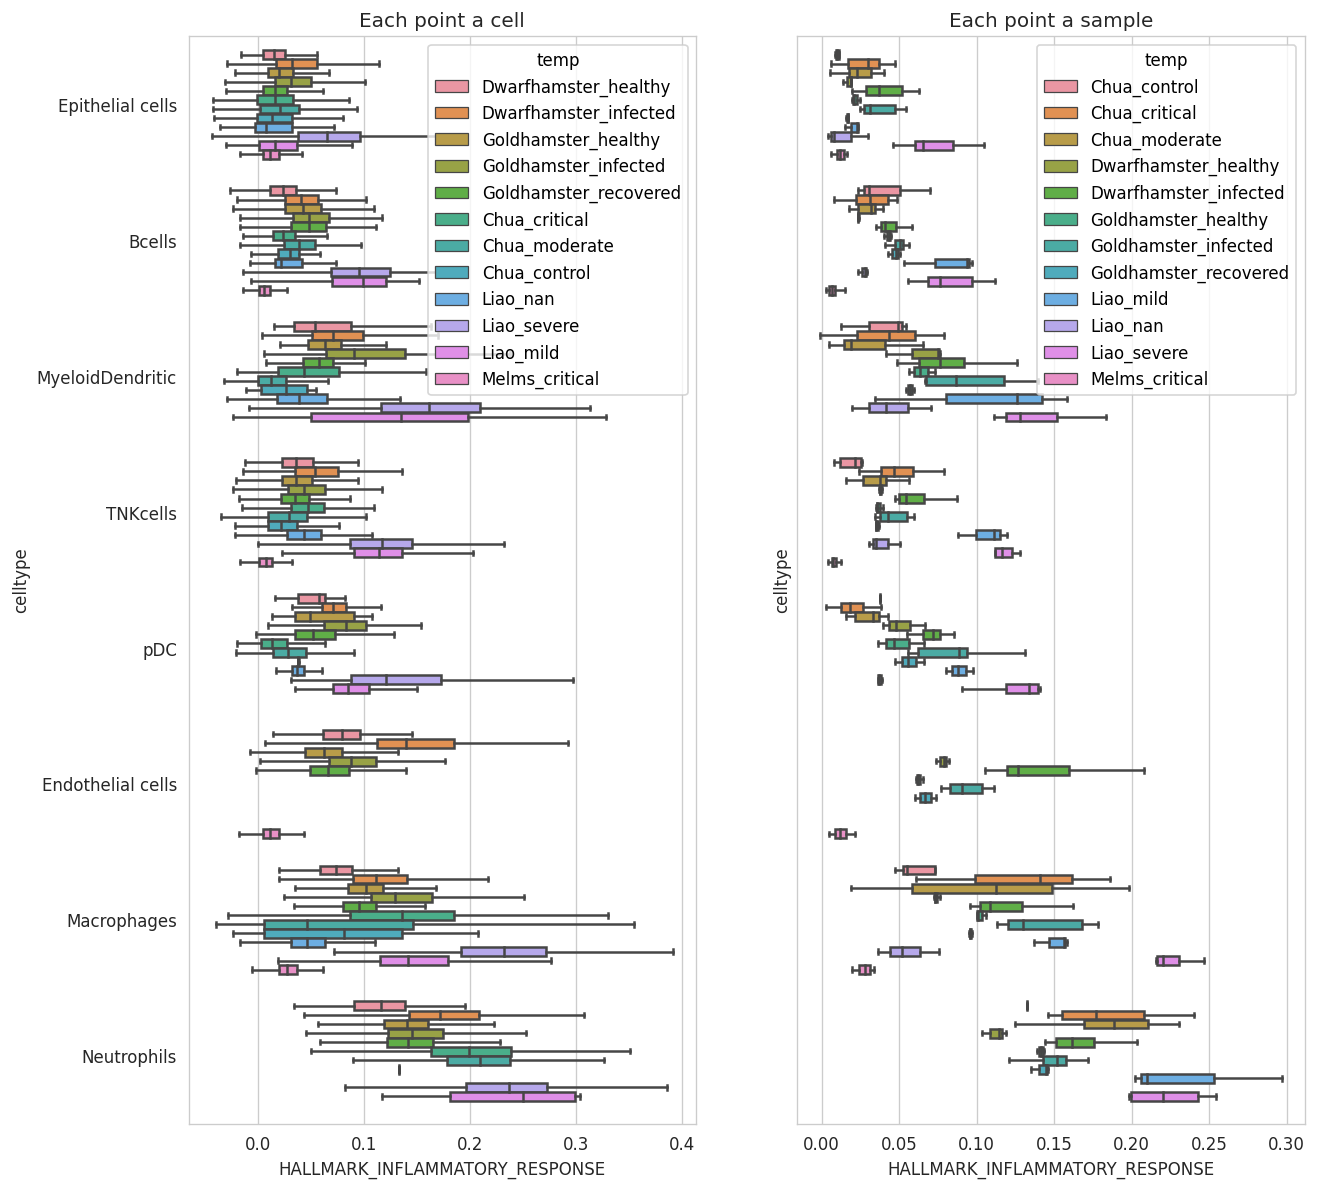

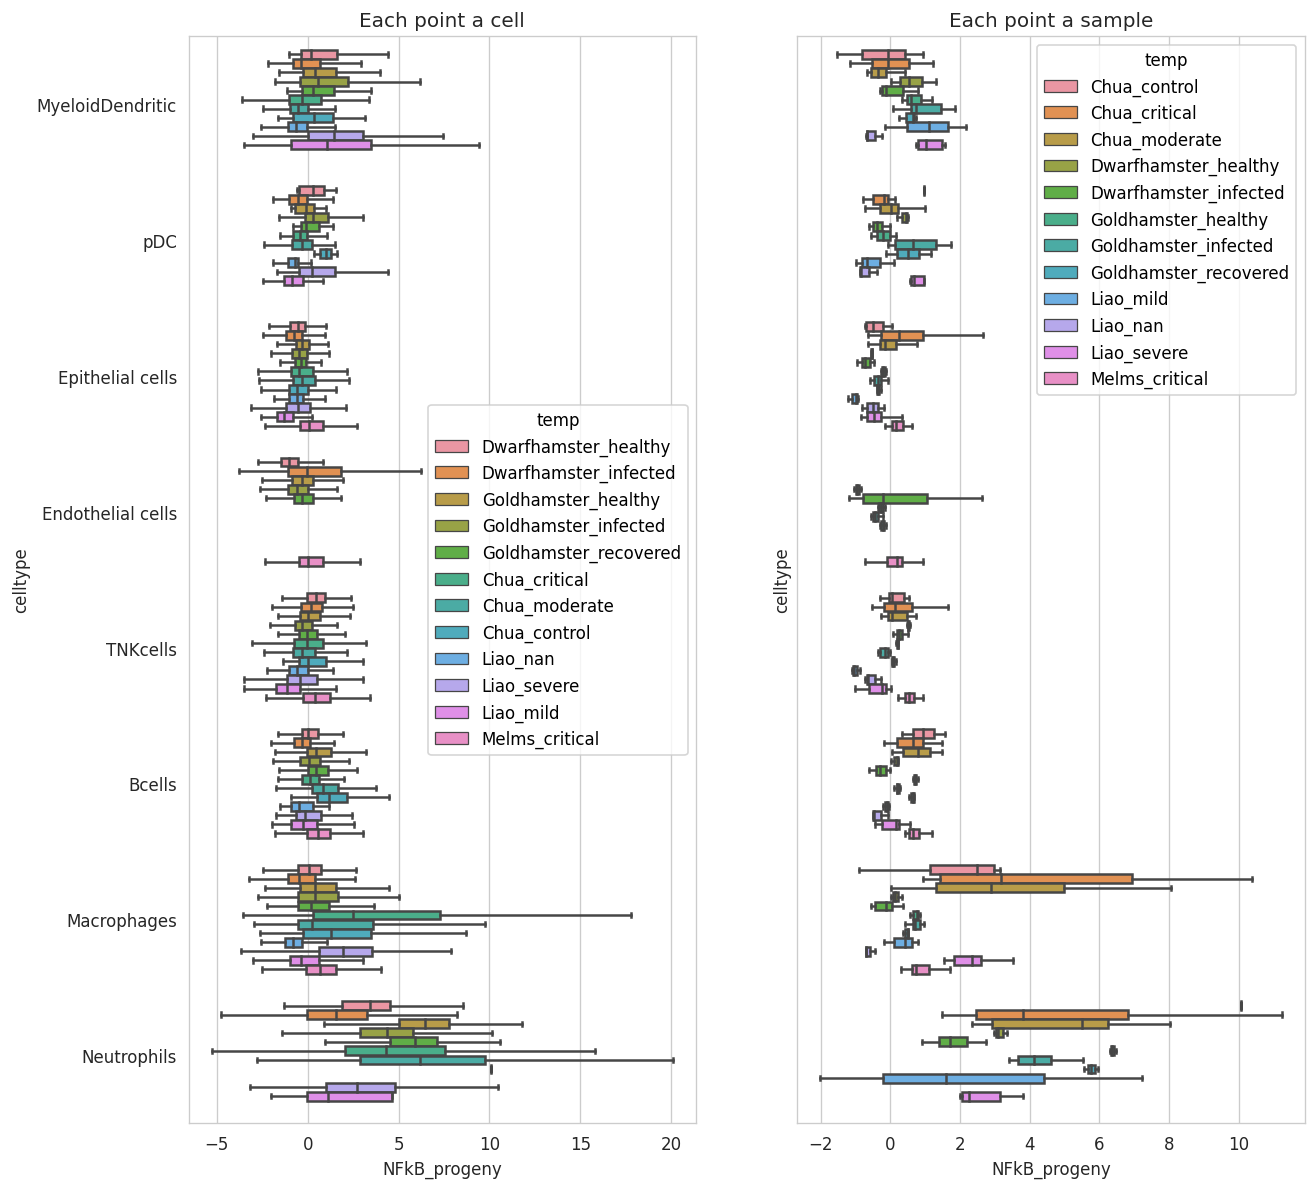

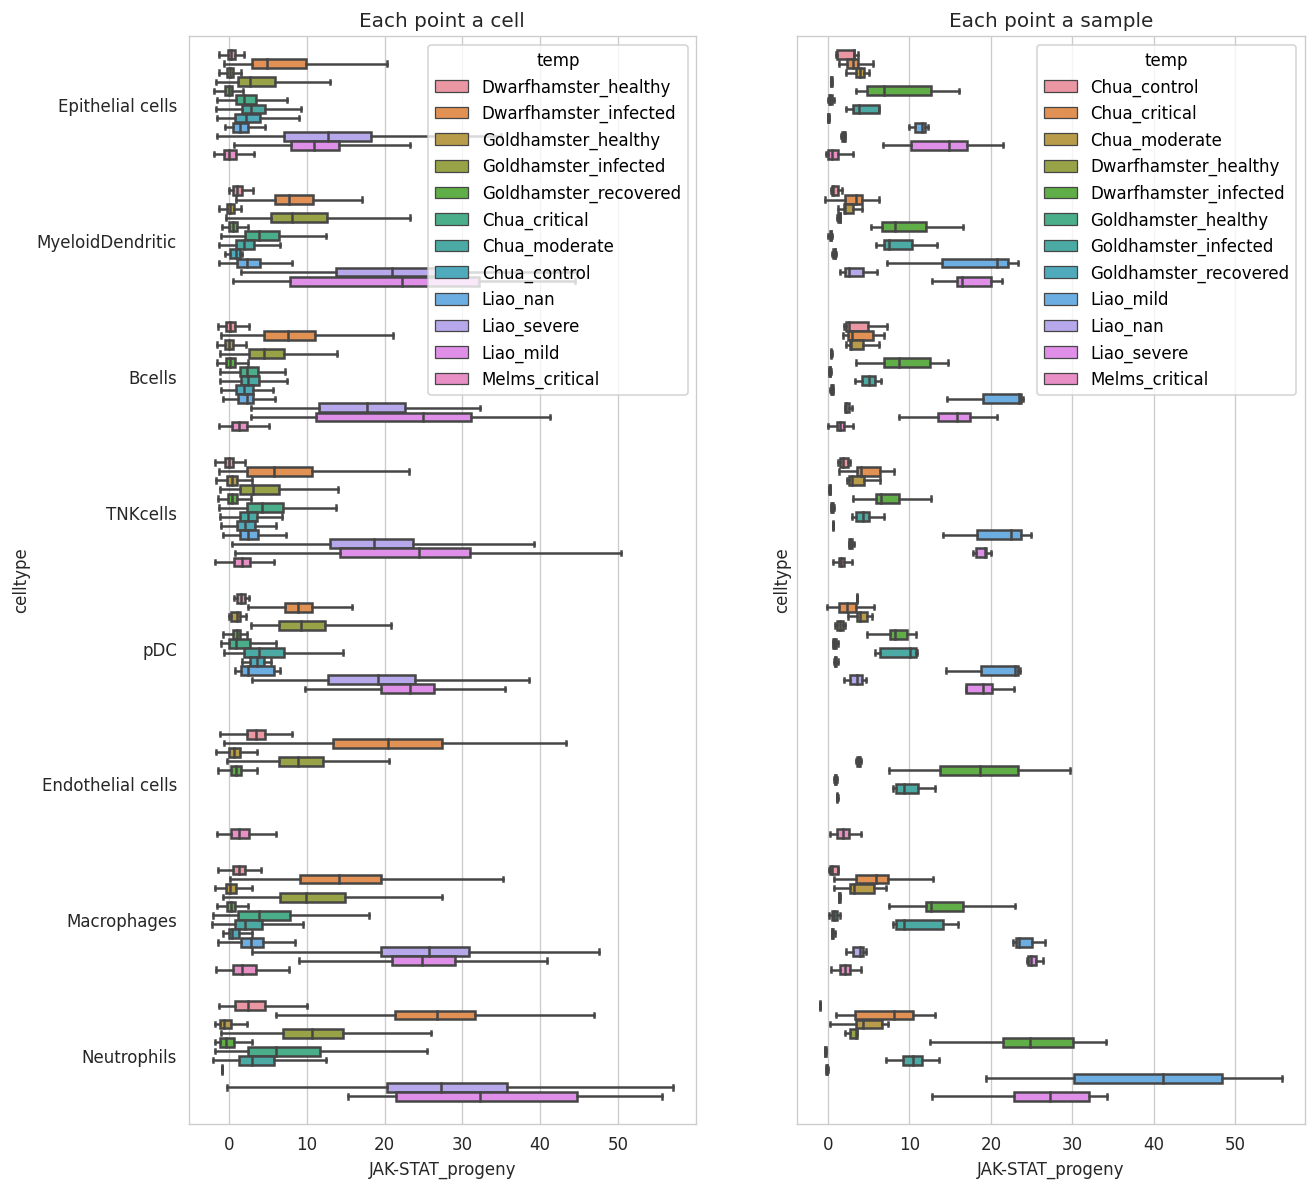

In [134]:
for key in ['HALLMARK_INFLAMMATORY_RESPONSE', 'NFkB_progeny', 'JAK-STAT_progeny']:

    order = df.groupby(groupby).mean()[key].sort_values().index
    with sns.axes_style('whitegrid'):
        fig, axs = pl.subplots(1, 2, figsize=[6*2,12], dpi=120, sharex=False, sharey=True)

    # each point a cell
    ax=axs[0]
    sns.boxplot(data=df, y=groupby, x=key, showfliers=False, order=order, hue=hue, dodge=True, ax=ax)
    ax.set_xlabel(key)
    ax.set_ylabel(groupby)
    ax.set_title('Each point a cell')

    # each point a sample
    ax=axs[1]
    sdf = df.groupby([groupby, 'temp', 'sample_id']).mean().reset_index()
    sns.boxplot(data=sdf, y=groupby, x=key, showfliers=False, order=order, hue=hue, dodge=True, ax=ax)
    ax.set_xlabel(key)
    ax.set_ylabel(groupby)
    ax.set_title('Each point a sample')

    # pl.savefig(f'{figure_path}Hamsters_box_inflammatory_activity_per_celltype.pdf', bbox_inches='tight')
    pl.show()